In [76]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table, join, Column

from astropy.io import ascii
import glob, re

% matplotlib inline

import matplotlib as mpl
from matplotlib import rc

mpl.style.use('seaborn-colorblind')

#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=18               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']


## This notebook reads in Keith's abundances and Guy's asteroseismology to produce the tables for the paper.

In [2]:
fname_diff = "../data/abundances/Pope_abundances_diff_arcturus.fits"
fname_nodiff = "../data/abundances/Pope_abundances_nodiff.fits"

In [3]:
diff = Table.read(fname_diff)
diff.sort('Object')
nodiff = Table.read(fname_nodiff)
nodiff.sort('Object')

How do abundances compare between the differential and non-differential methods? Not too badly. Many more elements lack differential abundances than absolute abundances so it looks like in the paper we shouldn't use the differential. Good to include in online data though.

In [4]:
# for j, key in enumerate(diff.keys()[1:]):
#     if key[0]=='e':
#         continue
#     plt.figure(j)
#     plt.plot(diff[key],nodiff[key],'.')
#     plt.title(key)

In [5]:
# nodiff

In [6]:
elements = filter(lambda x: x[0]!='e', nodiff.keys()[1:])
# print elements

### Create a string-formatted table merging abundances with their uncertainties appropriately.

In [7]:
newtab = Table([Column([str(obj).replace('_',' ') for obj in nodiff['Object']],name='Object')])

for el in elements[:8]:
    if el == 'O_Fe':
        continue
    col = nodiff[el]
    ecol = nodiff['e%s' % el]
    test = Column(['--' if 'nan' in str(col[j]) else '$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name='[%s/Fe]' % el.replace('_Fe',''))
#     test = Column(['$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=el.replace('_Fe',''))

    newtab.add_column(test)
    
#     print el


newtab2 = Table([Column([str(obj).replace('_',' ') for obj in nodiff['Object']],name='Object')])

for el in elements[8:15]:
    col = nodiff[el]
    ecol = nodiff['e%s' % el]
    test = Column(['--' if 'nan' in str(col[j]) else '$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name='[%s/Fe]' % el.replace('_Fe',''))
#     test = Column(['$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=el.replace('_Fe',''))

    newtab2.add_column(test)
    
newtab3 = Table([Column([str(obj).replace('_',' ') for obj in nodiff['Object']],name='Object')])

for el in elements[15:]:
    col = nodiff[el]
    ecol = nodiff['e%s' % el]
    test = Column(['--' if 'nan' in str(col[j]) else '$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name='[%s/Fe]' % el.replace('_Fe',''))
#     test = Column(['$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=el.replace('_Fe',''))

    newtab3.add_column(test)

    
# newtab_diff = Table([diff['Object']])

# for el in elements:
#     col = diff[el]
#     ecol = diff['e%s' % el]
#     test = Column(['--' if 'nan' in str(col[j]) else '%.2f $\pm$ %.2f' % (col[j],ecol[j]) for j, x in enumerate(col)],name=el.replace('_Fe',''))
# #     test = Column(['$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=el.replace('_Fe',''))

#     newtab_diff.add_column(test)


In [8]:
def oxford_join(string_list):
    '''From https://stackoverflow.com/questions/19838976/grammatical-list-join-in-python'''
    if len(string_list) < 1:
        text = ''
    elif len(string_list) == 1:
        text = string_list[0]
    elif len(string_list) == 2:
        text = ' and '.join(string_list)
    else:
        text = ', '.join(string_list)
        text = '{parts[0]}, and {parts[2]}'.format(parts=text.rpartition(', '))  # oxford comma
    return text

## Now produce three LaTeX tables to go into the paper directory.

In [9]:
latexdict = ascii.latex.latexdicts['AA'].copy()
latexdict['tabletype']= 'table*'

caption1 = r'Chemical abundances relative to iron for stars in the red giant sample as determined by BACCHUS, without differential line-by-line comparison to Arcturus, as described in Section~\ref{spectroscopy}, for the elements %s. Dashes indicate elements for which abundances could not be reliably computed.' % oxford_join([el.replace('_Fe','') for el in filter(lambda x: x !='O_Fe',elements[0:8])])
caption2 = r'Chemical abundances relative to iron for stars in the red giant sample as determined by BACCHUS, without differential line-by-line comparison to Arcturus, as described in Section~\ref{spectroscopy}, for the elements %s. Dashes indicate elements for which abundances could not be reliably computed.' % oxford_join([el.replace('_Fe','') for el in elements[8:15]])
caption3 = r'Chemical abundances relative to iron for stars in the red giant sample as determined by BACCHUS, without differential line-by-line comparison to Arcturus, as described in Section~\ref{spectroscopy}, for the elements %s. Dashes indicate elements for which abundances could not be reliably computed.' % oxford_join([el.replace('_Fe','') for el in elements[15:]])

caption1 = caption1+r'The catalogue of abundances for more elements continues in Tables~\ref{elems2} and~\ref{elems3}.'
caption2 = caption2+r'The catalogue of abundances for more elements continues in Table~\ref{elems3}.'


newtab.write('../paper/abundances_1.tex',format='latex',latexdict=latexdict,caption=caption1+'\label{elems1}',overwrite=True)
newtab2.write('../paper/abundances_2.tex',format='latex',latexdict=latexdict,caption=caption2+'\label{elems2}',overwrite=True)
newtab3.write('../paper/abundances_3.tex',format='latex',latexdict=latexdict,caption=caption3+'\label{elems3}',overwrite=True)

### Now let's also do the stellar properties

In [10]:
fname_merged ="../data/abundances/final_pope_merged.fits"
astero_logg = Table.read('pope_asteroseismology.csv')
merged = Table.read(fname_merged)
merged.rename_column('RVerr','RV_err')
merged.keys()
merged.sort('Object')
joint = join(merged,astero_logg,keys='Object')

In [11]:
counter = []
counter2 = []
for obj in merged['Object']:
    if obj not in astero_logg['Object']:
#         print obj
        counter.append(obj)
for obj in astero_logg['Object']:
    if obj not in merged['Object']:
#         print obj
        counter2.append(obj)

# print len(counter)
# print len(counter2)
# print counter

In [12]:
for j, obj in enumerate(astero_logg['Object']):
    ind = merged['Object']==obj
    merged[ind]['log_g'] = astero_logg['log_g'][j]
    merged[ind]['log_g_err'] = astero_logg['log_g_err'][j]

In [13]:
newtab = Table([Column([str(obj).replace('_',' ') for obj in joint['Object']],name='Object')])

newkeys = ['RV', 'Teff', 'log_g', 'monh','vsini','SNRe']
names = [r'RV',r'\teff', r'\logg',r'[M/H]',r'$V\sin{i}$',r'SNR']
units = [r'(km/s)', r'(K)', '','','(km/s)','']

for k, key in enumerate(newkeys):
    col = joint[key]
    if key+'_err' in joint.keys():
        ecol = joint['%s_err' % key]
        if 'Teff' in key:
            test = Column(['--' if 'nan' in str(col[j]) else '$%.0f \pm %.0f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=names[k])
        else:
            test = Column(['--' if 'nan' in str(col[j]) else '$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=names[k])
    else:
        test = Column(['%.1f' % (col[j]) for j, x in enumerate(col)],name=names[k])
    
    newtab.add_column(test)


In [14]:
# newtab

In [15]:
latexdict = ascii.latex.latexdicts['AA'].copy()
latexdict['tabletype']= 'table*'
latexdict['units'] = dict(zip(names,units))

caption = r'Fundamental stellar parameters for the red giant sample as determined jointly by asteroseismology (asteroseismic \logg; Section~\ref{asteroseismology}) and spectroscopy (%s; Section~\ref{spectroscopy}.)' % oxford_join(names)  
caption = caption+r'\label{stellar_props}'
newtab.write('../paper/stellar_props.tex',format='latex',latexdict=latexdict,caption=caption+'\label{stellar_props}',overwrite=True)


### Now let's look at the proper spectroscopy with Dnu measurements

In [16]:
fname_seismic = "../data/smear_Dnu.csv"
seismic = Table.read(fname_seismic)
seismic.sort('Star_ID')

In [17]:
seismic

Star_ID,Dnu,Dnu_err,Numax,Numax_err,eps,eps_err
str10,float64,float64,float64,float64,float64,float64
BD+36_3564,0.9490949804411055,0.030097283743239316,5.079062736733746,0.09882652247868091,0.8305746287171062,0.20003026391376488
BD+39_3577,1.6836250688792482,0.01363988821142889,13.266855807051439,0.31633186319569034,0.7409609522947077,0.06299253167276896
BD+42_3150,4.221788591943251,0.028504804862306103,38.315943379269186,0.9588694546996247,0.7013731801198373,0.07075600621249865
BD+43_3171,0.41728859981040545,0.05318387492844148,1.984298734336489,0.05145104900196677,0.8040170562496404,0.17159665699501567
BD+43_3213,0.48750734592283734,0.006958633078022336,2.5632797174106847,0.06325084146747773,1.0124195735754942,0.07326685394355063
BD+48_2904,2.8511597676805804,0.010318892608438912,23.13453453354469,0.7225398099392429,0.8563054208127122,0.08052669688943252
BD+48_2955,0.8953098233940573,0.0068208356847463585,5.440132725276065,0.08331498484403516,0.8105480979445374,0.052471147709803705
HD_174020,0.5639183284003043,0.01603666749035637,2.47548965209216,0.09744999575175439,0.8926590744791576,0.08467569516842773
HD_174829,1.2833572675283929,0.011357043983480081,7.9497984768617815,0.1571667547811646,0.7755393571480604,0.05755641850899791


In [18]:
newtab = Table([Column([str(obj).replace('_',' ') for obj in seismic['Star_ID']],name='Object')])

newkeys = ['Dnu', 'Numax', 'eps']
names = [r'\Dnu',r'\numax', r'$\epsilon$']
units = [r'(\muHz)', r'(\muHz)','']

for k, key in enumerate(newkeys):
    col = seismic[key]
    if key+'_err' in seismic.keys():
        ecol = seismic['%s_err' % key]
        if 'Teff' in key:
            test = Column(['--' if 'nan' in str(col[j]) else '$%.0f \pm %.0f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=names[k])
        else:
            test = Column(['--' if 'nan' in str(col[j]) else '$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=names[k])
    else:
        test = Column(['%.1f' % (col[j]) for j, x in enumerate(col)],name=names[k])
    
    newtab.add_column(test)

latexdict = ascii.latex.latexdicts['AA'].copy()
latexdict['tabletype']= 'table'
latexdict['units'] = dict(zip(names,units))

caption = r'Bulk asteroseismic parameters %s for the red giant sample as discussed in Section~\ref{asteroseismology}.' % oxford_join(names)  
caption = caption+r'\label{astero_table}'
newtab.write('../paper/astero_table.tex',format='latex',latexdict=latexdict,caption=caption+'\label{stellar_props}',overwrite=True)


### Notes on individual stars from Guy Davies

BD+39_388 - No secure detection.

BD+43_306 - Big peaks but not consistent enough with RG pattern.

HD_179959 - Pattern is too complicated - is this two stars??  Literature says no.

HD_185351 - Odd mode envelope - No explanation.

HD_187217 - No info on this star - maybe a double but very difficult to tell.

HD_188639 - Too difficult to get a robust Dnu.

HD_188875 -  Too difficult to get a robust Dnu.

HD_188629 - Too difficult to get a robust Dnu.



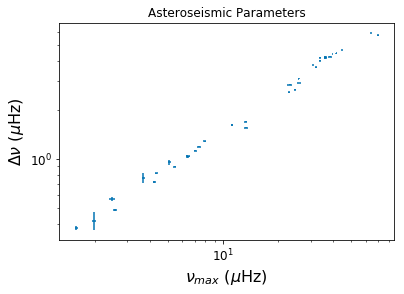

In [19]:
# the stars follow the expected numax-Dnu relation
plt.errorbar(seismic['Numax'],seismic['Dnu'],xerr=seismic['Numax_err'],yerr=seismic['Dnu_err'],linestyle='none')
plt.xlabel(r'$\nu_{max}$ ($\mu$Hz)')
plt.ylabel(r'$\Delta\nu$ ($\mu$Hz)')
plt.title('Asteroseismic Parameters')
plt.xscale('log')
plt.yscale('log')

### Which ones are missing?

In [20]:
badstars = ['BD+39_388','BD+43_306','HD_179959','HD_185351','HD_187217','HD_188639','HD_188875','HD_188629']
notes = ['No secure detection','Not consistent with RG pattern','Possible contamination',r'\citep{2017MNRAS.464.3713H}',
         'Possible contamination or binary',r'Too difficult to get a robust \Dnu',r'Too difficult to get a robust \Dnu',
         r'Too difficult to get a robust \Dnu']

notecol = [notes[j] if star in badstars else '' for j, star in enumerate(seismic['Star_ID'])]

In [21]:
np.sort(badstars)

array(['BD+39_388', 'BD+43_306', 'HD_179959', 'HD_185351', 'HD_187217',
       'HD_188629', 'HD_188639', 'HD_188875'], dtype='|S9')

In [22]:
for star in merged['Object']:
    if star not in seismic['Star_ID']:
        print star

BD+43_3064
HD_179959
HD_185351
HD_187217
HD_188629
HD_188875


In [23]:
for star in seismic['Star_ID']:
    if star not in merged['Object']:
        print star

BD+42_3150
BD+48_2904
HD_176209
HD_182354
HD_189636
HD_189750


## Read the main catalogue

In [24]:
fname_cat = '../data/catalogue.csv'
cat = Table.read(fname_cat,format='ascii')
cat.sort('kepmag')

In [25]:
# cat

In [26]:
# print 'Clump Candidates:',oxford_join([name.replace('_',' ') for name in cat[np.array(['clump' in thing for thing in list(cat['Notes'].data.data[:])])]['Name']])

### Now to get SIMBAD queries

In [27]:
from astroquery.simbad import Simbad
from astropy import coordinates as coord
from astropy import units as u


In [28]:
Simbad.reset_votable_fields()
Simbad.add_votable_fields('sptype')
sim = Simbad.query_objects(cat['Name'])
sim.write('smear_intermediate.csv',overwrite=True)
sim = Table.read('smear_intermediate.csv')
c = coord.SkyCoord(ra=sim['RA'], dec=sim['DEC'],unit=(u.hourangle, u.deg), frame='icrs')


In [29]:
new = Table([Column([cc.ra.deg for cc in c],name='RA',unit='deg',description='RA'),Column([cc.dec.deg for cc in c],name='Dec',unit='deg',description='Dec')],masked=False)
# new.write('../data/smear_simbad.csv',overwrite=True)

We then use the gaia tap service at http://gaia.ari.uni-heidelberg.de/tap.html for crossmatch 
using the command

SELECT bj.source_id, sm.ra, sm.dec, sm.phot_g_mean_mag, bj.r_est, bj.r_lo, bj.r_hi
FROM gaiadr2_complements.geometric_distance as bj 
JOIN TAP_UPLOAD.smear AS sm ON sm.source_id = bj.source_id

In [30]:
gaia = Table.read('../data/gaia_new.csv')
gaia[gaia['source_id']==2128480311802353536]

input_position,distance,source_id,designation,ra,dec,l,b,ecl_lon,ecl_lat,parallax,pmra,pmdec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,ra_error,dec_error,parallax_error,pmra_error,pmdec_error,a_g_percentile_lower,a_g_percentile_upper,a_g_val,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_gof_al,astrometric_matched_observations,astrometric_n_bad_obs_al,astrometric_n_good_obs_al,astrometric_n_obs_ac,astrometric_n_obs_al,astrometric_params_solved,astrometric_primary_flag,astrometric_pseudo_colour,astrometric_pseudo_colour_error,astrometric_sigma5d_max,astrometric_weight_al,bp_g,bp_rp,dec_parallax_corr,dec_pmdec_corr,dec_pmra_corr,duplicated_source,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,e_bp_min_rp_val,flame_flags,frame_rotator_object_type,g_rp,lum_percentile_lower,lum_percentile_upper,lum_val,matched_observations,mean_varpi_factor_al,parallax_over_error,parallax_pmdec_corr,parallax_pmra_corr,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_n_obs,phot_bp_rp_excess_factor,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_n_obs,phot_proc_mode,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_n_obs,phot_variable_flag,pmra_pmdec_corr,priam_flags,ra_dec_corr,radial_velocity,radial_velocity_error,radius_percentile_lower,radius_percentile_upper,radius_val,random_index,ra_parallax_corr,ra_pmdec_corr,ra_pmra_corr,ref_epoch,rv_nb_transits,rv_template_fe_h,rv_template_logg,rv_template_teff,solution_id,teff_percentile_lower,teff_percentile_upper,teff_val,visibility_periods_used,other_ids
str37,float64,int64,str28,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,int64,float64,float64,float64,int64,str13,float64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,int64,float64,float64,float64,int64,str28
"292.8180758333333,47.4810425",3.045468683588237e-07,2128480311802353536,Gaia DR2 2128480311802353536,292.81807623838415,47.48104263345887,79.74870041852522,13.41873522969091,313.2763085812297,67.52199730593198,--,--,--,6.813094,6.958596,6.607133,0.9129593534678879,0.9111506259110029,--,--,--,--,--,--,2184183.8,10.558104629072224,41534.46944489842,621.83044,21,0,178,178,178,3,false,--,--,1.8702852,0.0074779573,0.14550209,0.35146332,--,--,--,false,--,--,--,--,0,0.20596123,--,--,--,35,0.02136786,--,--,--,22757088.525844857,41156.05079937947,552.94635,25,1.1562203,35490213.691373415,20109.96568065563,1764.8073,237,0,18277417.46653145,39762.3565107829,459.66635,24,NOT_AVAILABLE,--,130001,-0.090708636,--,--,--,--,--,1344301503,--,--,--,2015.5,0,--,--,--,1635721458409799680,7372.0,7750.0,7461.5,15,Gaia DR1 2128480307502062848


In [31]:
def abs_mag(app_mag,dist):
    return app_mag - 5.*(np.log10(dist) - 1.)

In [32]:


dists = Table.read('../data/dists_new.csv')
dists.insert_row(38,
                 vals={'source_id':2128480311802353536,'r_est':np.nan,'r_lo':np.nan,'r_hi':np.nan})
gaia = join(dists,gaia,keys='source_id')

args = np.argsort(new['RA'])
args2 = np.argsort(args)
gaia.sort('ra')
gaia = gaia[args2]


bp, rp, gg = gaia['phot_bp_mean_mag'], gaia['phot_rp_mean_mag'], gaia['phot_g_mean_mag']
abs_gg = abs_mag(gg,dists['r_est'])
gaia['abs_gg'] = abs_gg
gaia['bp_rp'] = bp-rp
abs_gg_hi = abs_mag(gg,dists['r_hi'])
abs_gg_lo = abs_mag(gg,dists['r_lo'])

In [33]:
# V2083_Cyg doesn't have a parallax
# dists.insert_row(38,
#                  vals={'source_id':2128480311802353536,'ra':292.818076238,'dec':47.481042633,
#                        'phot_g_mean_mag':6.81,'r_est':np.nan,'r_lo':np.nan,'r_hi':np.nan})


In [34]:
# check the RA/Dec are the same
# plt.plot(new['RA'],label='Input')
# plt.plot(gaia['ra'],label='Gaia')
# plt.legend()

In [35]:
# plt.plot(cat['kepmag'],gaia['phot_g_mean_mag'])

In [36]:
# cat[np.abs(gaia['phot_g_mean_mag']-cat['kepmag'])>0.75]#.sort(np.abs(dists['phot_g_mean_mag']-cat['kepmag']))

In [37]:
# gaia[np.abs(gaia['phot_g_mean_mag']-cat['kepmag'])>0.75]#.sort(np.abs(dists['phot_g_mean_mag']-cat['kepmag']))

In [38]:
# Table(gaia['source_id']).write('sources.csv')

In [39]:
# newcat = cat.copy()
brightkep = Table.read('../data/Bright_Kep_new.csv')
var = Table.read('../data/variability.csv')
newcat = join(cat,brightkep,keys='Name')
newcat = join(newcat,var,keys='Name')
newcat['SpType']=sim['SP_TYPE']
newcat.sort('kepmag')
fname_spc = '../data/spc_giants.csv'
spc_data = Table.read(fname_spc,format='ascii')

newcat['TRES?'] = ['TRES' if obj in spc_data['Object'] else '--' for obj in newcat['Name']]
newcat.add_column(gaia['source_id'])
# for col in ['r_est','r_lo','r_hi']:
#     newcat.add_column(gaia[col])
newcat = join(newcat,gaia['bp_rp','source_id','r_est','r_lo','r_hi','phot_g_mean_mag'],keys='source_id',join_type=u'left')

newcat.sort('Name')

In [40]:
gaia['Name'] = [newcat['Name'][newcat['source_id']==obj][0] for obj in gaia['source_id']]

gaia['TRES'] = [newcat['TRES?'][newcat['source_id']==obj][0] for obj in gaia['source_id']]
pdg = gaia.to_pandas()

In [41]:
for l, ccat in enumerate([newcat[:52],newcat[52:]]):

    newtab = Table([Column([str(obj).replace('_',' ') for obj in ccat['Name']],name='Object')])

    newkeys = ['Kepler_ID','SpType','kepmag', 'phot_g_mean_mag','bp_rp','r_est','TRES?','Class']
    names = [r'KIC',r'Spectral Type',r'$Kp$',r'$G$',r'$Bp-Rp$',r'\gaia Distance','TRES','Variability']
    units = ['',r'(SIMBAD)', r'(mag)','(mag)',r'(mag)','(pc)','','Class']
    
    translator_class = {'LPV':'LPV',
                        'RG':'RG',
                        'GD/DS Hybrid':r'$\gamma\,\text{Dor} /\delta\,\text{Sct}$',
                        'GD':r'$\gamma\,\text{Dor}$',
                        'DS':r'$\delta\,\text{Sct}$',
                        '?':'?',
                        '-':r'--',
                        'Hump & Spike':'H+S',
                        'EV':'EV',
                        'EB':'EB',
                        'SPB':'SPB',
                        'Irregular':'Irregular',
                        'a2cvn':r'$\alpha^2\,\text{CVn}$',
                        'RM':r'RM',
                        'Eruptive':r'Eruptive'
                       }

    for k, key in enumerate(newkeys):
        col = ccat[key]
        if 'RE' in key:
            test = Column(['\checkmark' if 'TRES' in entry else '--' for entry in col],name=names[k])
        elif 'bs' in key:
            test = Column([entry.replace('under','') if 'under' in entry else 'unobserved' for entry in col],name=names[k])
        elif 'ype' in key:
            test = Column(['--' if np.ma.is_masked(entry) else entry for entry in col],name=names[k])
        elif 'est' in key:
            upcol = ccat['r_hi']
            downcol = ccat['r_lo']
            test = Column(['--' if 'nan' in str(col[j]) else '$%.1f^{+%.1f}_{-%.1f}$' % (col[j],upcol[j]-col[j],col[j]-downcol[j]) for j, x in enumerate(col)],name=names[k])
        elif key =='Class':
            test = Column([translator_class[entry] for entry in col],name=names[k])
        elif 'mag' in key:
            test = Column(['%.3f' % d for d in col.data],name=names[k])
        elif 'bp' in key:
            test = Column(['%.3f' % d for d in col.data],name=names[k])
        else:
            test = Column(col.data,name=names[k])
#         if key == 'TRES?':
#             test = Column(['TRES' if newtab['Object'][j].replace(' ','_') in merged['Object'] else '--' for j,entry in enumerate(col)], name=names[k])
        newtab.add_column(test)
    
    latexdict = ascii.latex.latexdicts['AA'].copy()
    latexdict['tabletype']= 'table*'
    latexdict['units'] = dict(zip(names,units))
    if l == 0:
        caption = r"The full set of underobserved and unobserved stars for which new light curves have been produced in this smear catalogue. \
        Calibrated \gaia distances are from \citet{gaiadists}. \
        Some objects, such as HD~185351, were observed in long cadence in some quarters and short cadence in others, and this is noted accordingly. \
        The eclipsing binary V2083~Cyg was detected by \gaia, but a parallax could not be obtained in DR2, possibly due to binary motion.\
        Variability classes are determined by inspection, having their usual abbreviations. \
        EV denotes an ellipsoidal variable, and RM rotational modulation, though these two can appear similar. $\alpha^2\,\text{CVn}$ variables are chemically-peculiar stars with rotational spot modulation,\
        and are noted separately from RM without chemical peculiarity.\
        $\gamma\,\text{Dor} /\delta\,\text{Sct}$ denotes a $\gamma\,\text{Dor} /\delta\,\text{Sct}$ hybrid, not uncertainty.\
        H+S denotes a `hump and spike' star.\
        Question marks indicate uncertainty, and dashes -- that no significant variability is observed." 
        caption = caption+r'\label{all_stars}'
        newtab.write('../paper/all_stars.tex',format='latex',latexdict=latexdict,caption=caption+'\label{all_stars}',overwrite=True)
        print 'Written %s' % '../paper/all_stars.tex'
    else:
        latexdict['preamble'] = '\contcaption{The full set of underobserved and unobserved stars for which new light curves have been produced in this smear catalogue. Calibrated \gaia distances are from \citet{gaiadists}. \label{all_stars_cont}}'
        newtab.write('../paper/all_stars2.tex',format='latex',latexdict=latexdict,overwrite=True)
        print 'Written %s' % '../paper/all_stars2.tex'
        

newtab = Table([Column([str(obj).replace('_',' ') for obj in newcat['Name']],name='Object')])

newkeys = ['Kepler_ID','SpType','kepmag', 'phot_g_mean_mag','r_est','Observed', 'TRES?','Class']
names = [r'KIC',r'Spectral Type',r'$Kp$',r'$G$',r'\gaia Distance',r'Observed','Spectroscopy','Variability']
units = ['',r'(SIMBAD)', r'(mag)','(mag)','(pc)','','','Class']

for k, key in enumerate(newkeys):
    col = newcat[key]
    if 'bs' in key:
        test = Column([entry.replace('under','') if 'under' in entry else 'unobserved' for entry in col],name=names[k])
    elif 'ype' in key:
        test = Column(['--' if np.ma.is_masked(entry) else entry for entry in col],name=names[k])
    elif 'est' in key:
        upcol = newcat['r_hi']
        downcol = newcat['r_lo']
        test = Column(['--' if 'nan' in str(col[j]) else '$%.1f^{+%.1f}_{-%.1f}$' % (col[j],upcol[j]-col[j],col[j]-downcol[j]) for j, x in enumerate(col)],name=names[k])
    elif key =='Class':
        test = Column([translator_class[entry] for entry in col],name=names[k])
    elif 'mag' in key:
        test = Column(['%.3f' % d for d in col.data],name=names[k])
    elif 'bp' in key:
        test = Column(['%.3f' % d for d in col.data],name=names[k])
    else:
        test = Column(col.data,name=names[k])
#     if key == 'TRES?':
#         test = Column(['TRES' if newtab['Object'][j].replace(' ','_') in merged['Object'] else '--' for j,entry in enumerate(col)], name=names[k])
    newtab.add_column(test)

latexdict = ascii.latex.latexdicts['AA'].copy()
latexdict['tabletype']= 'table*'
latexdict['units'] = dict(zip(names,units))


Written ../paper/all_stars.tex
Written ../paper/all_stars2.tex


In [42]:
col = ccat['r_est']
upcol = ccat['r_hi']
downcol = ccat['r_lo']
test = Column(['--' if 'nan' in str(col[j]) else '$%.2f^{+%.2f}_{-%.2f}$' % (col[j],upcol[j]-col[j],col[j]-downcol[j]) for j, x in enumerate(col)])


In [43]:
# for_keith = newcat['Name','ra','dec']
# for_keith.write('star_coords_keith.csv')

In [44]:
newcat

Name,SpType,[Fe/H],theta,Observed,Seasons,Teff,Log_G,E(B-V),g,r,J,kepmag,Edge_Dist,Notes,Collaborators,Interferometry?,TRES?,Kepler_ID,Class,source_id,bp_rp,r_est,r_lo,r_hi,phot_g_mean_mag
str10,str16,float64,float64,str29,int64,int64,float64,float64,float64,float64,float64,float64,int64,str84,str16,str3,str4,int64,str12,int64,float64,float64,float64,float64,float64
14_Cyg,G8.5IIIbFe-0.5,0.08,0.267,unobserved,4,--,--,--,5.334,5.394,5.365,5.49,0,"contact binary, interesting ramp at low freq",--,--,--,7292420,Hump & Spike,2077959092540451456,-0.054938400000000165,194.251074278231,187.684456735487,201.285145272043,5.3699827
BD+36_3564,F5II-III,--,--,unobserved,4,--,--,--,9.944,8.516,6.134,8.128,141,RG,--,--,TRES,1575741,RG,2051728490311183744,1.5440902999999997,547.117106264667,535.997662270272,558.699048472257,8.040623
BD+39_3577,G8III,--,--,unobserved,4,4870,2.513,0.057,8.819,8.062,6.636,8.131,217,RG,--,--,TRES,4989821,RG,2103507894472422656,1.1338274999999998,311.650670508792,308.9914182984,314.355261317156,8.089526
BD+39_3882,A2V,--,--,unobserved,4,6241,4.186,0.02,8.463,8.192,7.36,8.259,0,bad light curve,--,--,--,4850372,?,2076372669064227200,0.616321000000001,143.266948083662,142.59154490081,143.94866508398,8.158849
BD+42_3150,B9III,--,--,unobserved,4,4716,2.329,0.063,9.111,8.257,6.743,8.35,261,not sure,--,--,--,7091342,?,2116742544137540608,1.205577,545.954282342101,516.819773786676,578.502581535217,8.31532
BD+42_3367,B5V,--,--,unobserved,4,--,--,--,9.468,7.756,4.983,7.271,269,RG: low freq,--,--,TRES,7447756,LPV,2125866188548442240,2.020433699999999,761.98189491859,746.828779128639,777.751092763516,6.991751
BD+42_3393,M1III,--,--,unobserved,4,--,--,--,9.86,8.149,5.362,7.664,139,RG: low freq,--,--,TRES,6870455,LPV,2077747333469959168,1.952289099999999,928.952108024118,904.41632341393,954.830724423781,7.4138913
BD+43_3064,G7IIIa,--,--,unobserved,3,--,--,--,10.18,8.692,6.205,8.284,0,RG,--,--,TRES,8075287,RG,2117284053614333312,1.5986399999999996,641.029617229135,621.919910626924,661.328015894773,8.20331
BD+43_3068,B1.1III+B2.5/3V:,--,--,unobserved,4,5506,4.394,0.011,8.754,8.254,7.181,8.308,0,not good,--,--,--,8006792,-,2117267079903573504,0.8389476000000009,53.7738365747513,53.6508736699958,53.8973543593231,8.267944


## Now make an HR diagram

In [45]:
snrs = dists['r_est']/((dists['r_hi']-dists['r_lo'])/2.)
np.nanmedian(snrs)

71.39072222295582

In [46]:
errorbars = np.zeros((2,np.size(abs_gg)))
errorbars[0,:] = abs_gg_hi-abs_gg
errorbars[1,:] = abs_gg-abs_gg_lo

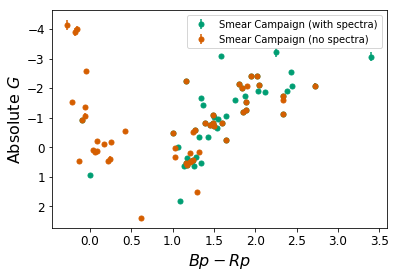

In [47]:
rc('text', usetex=False)
m = np.where(gaia['TRES']!='--')[0]
plt.errorbar(bp[m]-rp[m],abs_gg[m],yerr=errorbars[:,m],fmt='.',color=colours[1],label=r'Smear Campaign (with spectra)',markersize=10)
plt.errorbar(bp[~m]-rp[~m],abs_gg[~m],yerr=errorbars[:,~m],fmt='.',color=colours[2],label=r'Smear Campaign (no spectra)',markersize=10)
plt.gca().invert_yaxis()
plt.xlabel(r'$Bp-Rp$')
plt.ylabel(r'Absolute $G$')
plt.legend()

Now we want to use Megan Bedell's Gaia-Kepler crossmatch to situate these in the broader colour-magnitude diagram

In [48]:
kep_data = Table.read('../data/kepler_dr2_4arcsec.fits', format='fits')


In [49]:
kep_data['abs_gmag'] = kep_data['phot_g_mean_mag'] - \
                            5.*(np.log10(kep_data['r_est']) - 1.)
kep_data['abs_gmag'].unit = u.mag

In [50]:
newcat

Name,SpType,[Fe/H],theta,Observed,Seasons,Teff,Log_G,E(B-V),g,r,J,kepmag,Edge_Dist,Notes,Collaborators,Interferometry?,TRES?,Kepler_ID,Class,source_id,bp_rp,r_est,r_lo,r_hi,phot_g_mean_mag
str10,str16,float64,float64,str29,int64,int64,float64,float64,float64,float64,float64,float64,int64,str84,str16,str3,str4,int64,str12,int64,float64,float64,float64,float64,float64
14_Cyg,G8.5IIIbFe-0.5,0.08,0.267,unobserved,4,--,--,--,5.334,5.394,5.365,5.49,0,"contact binary, interesting ramp at low freq",--,--,--,7292420,Hump & Spike,2077959092540451456,-0.054938400000000165,194.251074278231,187.684456735487,201.285145272043,5.3699827
BD+36_3564,F5II-III,--,--,unobserved,4,--,--,--,9.944,8.516,6.134,8.128,141,RG,--,--,TRES,1575741,RG,2051728490311183744,1.5440902999999997,547.117106264667,535.997662270272,558.699048472257,8.040623
BD+39_3577,G8III,--,--,unobserved,4,4870,2.513,0.057,8.819,8.062,6.636,8.131,217,RG,--,--,TRES,4989821,RG,2103507894472422656,1.1338274999999998,311.650670508792,308.9914182984,314.355261317156,8.089526
BD+39_3882,A2V,--,--,unobserved,4,6241,4.186,0.02,8.463,8.192,7.36,8.259,0,bad light curve,--,--,--,4850372,?,2076372669064227200,0.616321000000001,143.266948083662,142.59154490081,143.94866508398,8.158849
BD+42_3150,B9III,--,--,unobserved,4,4716,2.329,0.063,9.111,8.257,6.743,8.35,261,not sure,--,--,--,7091342,?,2116742544137540608,1.205577,545.954282342101,516.819773786676,578.502581535217,8.31532
BD+42_3367,B5V,--,--,unobserved,4,--,--,--,9.468,7.756,4.983,7.271,269,RG: low freq,--,--,TRES,7447756,LPV,2125866188548442240,2.020433699999999,761.98189491859,746.828779128639,777.751092763516,6.991751
BD+42_3393,M1III,--,--,unobserved,4,--,--,--,9.86,8.149,5.362,7.664,139,RG: low freq,--,--,TRES,6870455,LPV,2077747333469959168,1.952289099999999,928.952108024118,904.41632341393,954.830724423781,7.4138913
BD+43_3064,G7IIIa,--,--,unobserved,3,--,--,--,10.18,8.692,6.205,8.284,0,RG,--,--,TRES,8075287,RG,2117284053614333312,1.5986399999999996,641.029617229135,621.919910626924,661.328015894773,8.20331
BD+43_3068,B1.1III+B2.5/3V:,--,--,unobserved,4,5506,4.394,0.011,8.754,8.254,7.181,8.308,0,not good,--,--,--,8006792,-,2117267079903573504,0.8389476000000009,53.7738365747513,53.6508736699958,53.8973543593231,8.267944


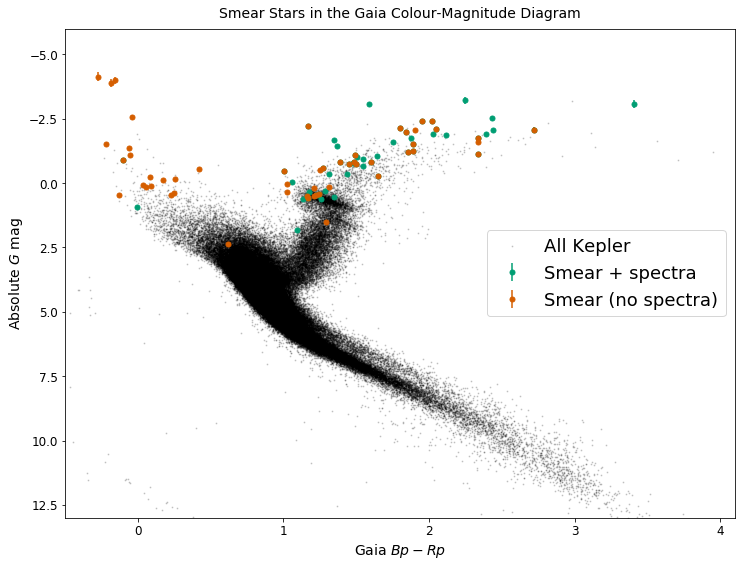

In [77]:
filter = (kep_data['phot_g_mean_mag'] <= 18.) & (kep_data['parallax'] > 0.1)
filter = (kep_data['phot_g_mean_mag'] <= 18.) & (kep_data['parallax_over_error'] > 25)

plt.scatter(kep_data['bp_rp'][filter], kep_data['abs_gmag'][filter], alpha=0.15, color='k', s=1,label='All Kepler')
m = np.where(gaia['TRES']!='--')[0]
plt.errorbar(bp[m]-rp[m],abs_gg[m],yerr=errorbars[:,m],fmt='.',color=colours[1],label=r'Smear + spectra',markersize=10)
plt.errorbar(bp[~m]-rp[~m],abs_gg[~m],yerr=errorbars[:,~m],fmt='.',color=colours[2],label=r'Smear (no spectra)',markersize=10)

plt.xlabel('Gaia $Bp-Rp$', fontsize=14)
plt.ylabel(r'Absolute $G$ mag', fontsize=14)
plt.ylim([13,-6])
plt.xlim([-0.5,4.1])
plt.legend()
plt.title(r'Smear Stars in the Gaia Colour-Magnitude Diagram',y=1.01,fontsize=14)
# plt.axvline(0.95) # separate giants and dwarfs 
plt.savefig('../paper/gaia_kepler_hr.png',bbox_inches='tight')

In [53]:
# filter = (kep_data['phot_g_mean_mag'] <= 18.) & (kep_data['parallax'] > 0.1)
# filter = (kep_data['phot_g_mean_mag'] <= 18.) & (kep_data['parallax_over_error'] > 25)

# plt.scatter(kep_data['bp_rp'][filter], kep_data['abs_gmag'][filter], alpha=0.15, color='k', s=1,label='All Kepler')
# m = np.where(gaia['TRES']!='--')[0]
# plt.errorbar(bp[m]-rp[m],abs_gg[m],yerr=errorbars[:,m],fmt='.',color=colours[1],label=r'Smear + spectra',markersize=10)
# plt.errorbar(bp[~m]-rp[~m],abs_gg[~m],yerr=errorbars[:,~m],fmt='.',color=colours[2],label=r'Smear (no spectra)',markersize=10)

# plt.xlabel('Gaia $Bp-Rp$', fontsize=14)
# plt.ylabel(r'Absolute $G$ mag', fontsize=14)
# plt.ylim([13,-6])
# plt.xlim([-0.5,4.1])
# plt.legend()
# plt.title(r'Smear Stars in the Gaia Colour-Magnitude Diagram',y=1.01,fontsize=14)
# # plt.axvline(0.95) # separate giants and dwarfs 
# plt.savefig('../paper/gaia_kepler_hr.png',bbox_inches='tight')

In [54]:
giants = (bp-rp>0.95)
dwarfs = (bp-rp<0.95)
print giants.sum(),'giants', dwarfs.sum(),'dwarfs',giants.sum()+dwarfs.sum(),'total'
# np.savetxt('giants.txt',cat['Name'][giants])
# np.savetxt('dwarfs.txt',cat['Name'][dwarfs])

66 giants 36 dwarfs 102 total


In [55]:
# # find weird stars in the HR diagram
# rc('text', usetex=False)
# plt.errorbar(bp[dwarfs]-rp[dwarfs],abs_gg[dwarfs],yerr=errorbars[:,dwarfs],fmt='.',color=colours[2],label=r'Dwarfs',markersize=10)
# plt.errorbar(bp[giants]-rp[giants],abs_gg[giants],yerr=errorbars[:,giants],fmt='.',color=colours[1],label=r'Giants',markersize=10)

# weird = ['HD_176582', 'HD_179395']
# for j,w in enumerate(weird):
#     ww = np.where(gaia['Name'] == w)[0]
#     plt.errorbar(bp[ww]-rp[ww],abs_gg[ww],yerr=errorbars[:,ww],fmt='.',color=colours[3+j],label=w,markersize=25)

# plt.gca().invert_yaxis()
# plt.xlabel(r'$Bp-Rp$')
# plt.ylabel(r'Absolute $G$')
# plt.legend()
# plt.savefig('hr_weird.png')

In [56]:
test = Table({'Giants':cat['Name'][giants].data.data.astype('S10')})
test.write('giants.txt',format='ascii',overwrite=True)

test = Table({'dwarfs':cat['Name'][dwarfs].data.data.astype('S10')})
test.write('dwarfs.txt',format='ascii',overwrite=True)

## Now compare to Hypatia

In [57]:
Simbad.reset_votable_fields()
Simbad.add_votable_fields('ids')
sim = Simbad.query_objects(cat['Name'])
ids = sim['IDS']

In [58]:
import re
hips = []
for eyedee in ids:
    m = re.search('\|HIP  (.+?)\|',str(eyedee))
    if m:
        found = m.group(1)
#     print found
    hips.append(found)

In [59]:
hinkel = Table.read('../data/hypatia-03082018.csv')

In [60]:
in_hyp = []
for j, hip in enumerate(hips):
    if int(hip) in hinkel['f_hip']:
        print hip, sim['MAIN_ID'][j]
        in_hyp.append((hip,sim['MAIN_ID'][j]))

96459 HD 185351
92831 HD 175740


In [61]:
in_hyp

[('96459', 'HD 185351'), ('92831', 'HD 175740')]

In [64]:
# import altair as alt
import pandas as pd

In [65]:
pdg = gaia.to_pandas()
pdg.assign(bprp=pdg.phot_bp_mean_mag - pdg.phot_rp_mean_mag);
pdg.insert(len(pdg.columns), 'bprp', pd.Series(pdg.phot_bp_mean_mag - pdg.phot_rp_mean_mag, index=pdg.index))
pdg.insert(len(pdg.columns), 'name', pd.Series(sim['MAIN_ID'], index=pdg.index))
spec = ['TRES' if sp else 'No  Spectra' for sp in pdg['TRES']=='TRES']
pdg.insert(len(pdg.columns), 'Spectroscopy', pd.Series(spec, index=pdg.index))
pdg.insert(len(pdg.columns), 'SpType', pd.Series(newcat['SpType'], index=pdg.index))

# pdkep = kep_data.to_pandas()

In [66]:
pdg.Spectroscopy

0             TRES
1      No  Spectra
2             TRES
3      No  Spectra
4      No  Spectra
5      No  Spectra
6             TRES
7             TRES
8      No  Spectra
9             TRES
10     No  Spectra
11     No  Spectra
12            TRES
13            TRES
14            TRES
15     No  Spectra
16            TRES
17            TRES
18            TRES
19            TRES
20     No  Spectra
21     No  Spectra
22     No  Spectra
23     No  Spectra
24     No  Spectra
25            TRES
26            TRES
27            TRES
28            TRES
29     No  Spectra
          ...     
72     No  Spectra
73            TRES
74     No  Spectra
75     No  Spectra
76            TRES
77            TRES
78            TRES
79            TRES
80            TRES
81            TRES
82            TRES
83     No  Spectra
84            TRES
85            TRES
86            TRES
87     No  Spectra
88     No  Spectra
89     No  Spectra
90            TRES
91            TRES
92     No  Spectra
93     No  S

### The *Kepler* dataset is too big for Altair. But not for Bokeh - let's copy from at demo.ipynb from github.com/megbedell/gaia-kepler.fun

In [67]:
from bokeh.plotting import *
from bokeh.io import output_notebook
from bokeh.models import OpenURL, Circle, HoverTool, PanTool, BoxZoomTool, ResetTool, SaveTool, TapTool, WheelZoomTool
from bokeh.util.hex import hexbin
from bokeh.transform import linear_cmap, factor_cmap
from bokeh.palettes import Spectral6
# output_notebook()
reset_output()
output_file("cmd_smear.html")


In [72]:
filter1 = (kep_data['phot_g_mean_mag'] <= 18.) & (kep_data['parallax_over_error'] > 25)
# filter2 = (kep_data['planet?'] == 'conf') & filter1

filter2 = filter1 

thin = 4

source = ColumnDataSource(
    data=dict(
        kepid=kep_data[filter2]['kepid'].data.data[::thin],
        kepmag=kep_data[filter2]['kepmag'].data.data[::thin],
        bp_rp=kep_data[filter2]['bp_rp'].data.data[::thin],
        abs_gmag=kep_data[filter2]['abs_gmag'].data.data[::thin],
        mass=kep_data[filter2]['mass'].data.data[::thin],
        radius=kep_data[filter2]['radius'].data.data[::thin]
        )
    )

source_smear = ColumnDataSource(
    data=dict(
        name=pdg.name.values,
        abs_gmag=pdg.abs_gg.values,
        bp_rp=pdg.bprp.values,
        spec=pdg.Spectroscopy.values,
        sptype=pdg.SpType.values
        )
    )


In [69]:
# dict(
#         name=pdg.name.values,
#         abs_gmag=pdg.abs_gg.values,
#         bp_rp=pdg.bprp.values,
#         spec=pdg.Spectroscopy.values,
#         sptype=pdg.SpType.values
#         )

In [73]:
%%time

xrange = (-0.5,4.1)
yrange = (13,-6)

fig = figure(tools="wheel_zoom,pan,reset",x_range=xrange,
        y_range=yrange,title="Smear Stars in the Gaia Colour-Magnitude Diagram")   
kep_render = fig.circle('bp_rp','abs_gmag', source=source, size=4, name='KICs',color='black',alpha=0.2)

smear_render = fig.circle('bp_rp','abs_gmag', source=source_smear, size=10, name='Smear',
                          color=factor_cmap('spec',palette=Spectral6,factors=pdg.Spectroscopy.values),legend='spec')
hover = HoverTool(renderers=[smear_render],
                    tooltips=[
        ("Name", "@name"),
        ("Sp. Type","@sptype"),
        ("Abs. G mag","@abs_gmag"),
        ("Bp-Rp","@bp_rp")
                            ]
    )
fig.add_tools(hover)
fig.legend.orientation = "vertical"
fig.legend.location = "bottom_left"

fig.xaxis.axis_label = 'Gaia Bp-Rp (mag)'
fig.yaxis.axis_label = 'Gaia Abs. G Mag'
fig.xaxis.axis_label_text_font_size = '14pt'
fig.xaxis.major_label_text_font_size = '12pt'
fig.yaxis.axis_label_text_font_size = '14pt'   
fig.yaxis.major_label_text_font_size = '12pt' 
save(fig)
# show(fig)


CPU times: user 1 s, sys: 29.9 ms, total: 1.03 s
Wall time: 1.03 s


In [92]:
# for j, star in enumerate(pdg.name.values):
#     print j, star, pdg.abs_gg.values[j]

### Let's see if Hipparcos parallaxes differ from Gaia

In [93]:
Simbad.reset_votable_fields()
Simbad.add_votable_fields('parallax')
sim = Simbad.query_objects(cat['Name'])
hip_par = sim['PLX_VALUE']


In [94]:
from astroquery.esasky import ESASky
esasky = ESASky()


In [95]:
hippar = []
for j, hip in enumerate(hips):
    print j, hip
    dummy = esasky.query_object_catalogs('HIP'+str(hip),catalogs='HIPPARCOS-2')[0]
    hippar.append(dummy['plx'].data.data[0])

0 96459
1 96825
2 92831
3 96288
4 96693
5 98194
6 97372
7 95352
8 97634
9 96805
10 98383
11 97774
12 94890
13 96449
14 98058
15 92713
16 93309
17 92891
18 94799
19 94351
20 93177
21 95245
22 92599
23 97845
24 95673
25 97304
26 95534
27 98610
28 94781
29 93210
30 92156
31 94659
32 95056
33 92116
34 96252
35 93749
36 94977
37 92869
38 96011
39 98071
40 95524
41 93204
42 94923
43 96517
44 96887
45 92455
46 93989


ConnectionError: ('Connection aborted.', BadStatusLine("''",))

In [ ]:
parallaxes_hip = np.array(hippar)

In [ ]:
plt.plot(gaia['phot_g_mean_mag'],gaia['parallax']/parallaxes_hip,'.',markersize=12,label='Gaia/Hipparcos')
plt.axhline(1.,color=colours[1],label='1')
plt.legend()
plt.xlabel(r'Gaia $G$ mag')
plt.ylabel('Parallax Ratio')
plt.title('Comparison of Gaia and Hipparcos Parallaxes',y=1.01)
plt.savefig('gaiavship.png')

In [ ]:
plt.plot(gaia['parallax'],parallaxes_hip,'.')
plt.plot(gaia['parallax'],gaia['parallax'],'-')

In [ ]:
plt.hist(gaia['parallax']/parallaxes_hip,bins=20);
plt.axvline(1,color=colours[2])

### Now let's check everything against the Bright_Kep overall bright kepler catalogue

In [64]:
# import sys
# reload(sys)
# sys.setdefaultencoding('utf8')

brightkep = Table.read('../data/Bright_Kep_new.csv')
# reload(sys)


In [65]:
brightkep.sort('Name')

In [67]:
test = join(cat,brightkep,keys='Name')
test.sort('Name')
test

Name,SpType,[Fe/H],theta,Observed,Seasons,Teff,Log_G,E(B-V),g,r,J,kepmag,Edge_Dist,Notes,Collaborators,Interferometry?,TRES?,Kepler_ID
str10,str15,float64,float64,str29,int64,int64,float64,float64,float64,float64,float64,float64,int64,str84,str16,str3,str3,int64
14_Cyg,B9III,0.08,0.267,unobserved,4,--,--,--,5.334,5.394,5.365,5.49,0,"contact binary, interesting ramp at low freq",--,--,--,7292420
BD+36_3564,K5,--,--,unobserved,4,--,--,--,9.944,8.516,6.134,8.128,141,RG,--,--,--,1575741
BD+39_3577,G5,--,--,unobserved,4,4870,2.513,0.057,8.819,8.062,6.636,8.131,217,RG,--,--,--,4989821
BD+39_3882,F5,--,--,unobserved,4,6241,4.186,0.02,8.463,8.192,7.36,8.259,0,bad light curve,--,--,--,4850372
BD+42_3150,K0,--,--,unobserved,4,4716,2.329,0.063,9.111,8.257,6.743,8.35,261,not sure,--,--,--,7091342
BD+42_3367,M0,--,--,unobserved,4,--,--,--,9.468,7.756,4.983,7.271,269,RG: low freq,--,--,--,7447756
BD+42_3393,K5,--,--,unobserved,4,--,--,--,9.86,8.149,5.362,7.664,139,RG: low freq,--,--,--,6870455
BD+43_3064,K5,--,--,unobserved,3,--,--,--,10.18,8.692,6.205,8.284,0,RG,--,--,--,8075287
BD+43_3068,G0,--,--,unobserved,4,5506,4.394,0.011,8.754,8.254,7.181,8.308,0,not good,--,--,--,8006792


In [42]:
cat

Name,SpType,[Fe/H],theta,Observed,Seasons,Teff,Log_G,E(B-V),g,r,J,kepmag,Edge_Dist,Notes,Collaborators,Interferometry?,TRES?
str10,str15,float64,float64,str29,int64,int64,float64,float64,float64,float64,float64,float64,int64,str84,str16,str3,str3
HD_185351,G9IIIbCN,0.16,1.156,LC:Q1-3 SC:Q16 under,4,--,--,--,6.091,5.176,3.654,5.034,59,RG: Retired A star,Hjorringgaard,--,Yes
HD_186155,F5II-III,0.3,0.57,LC:Q1 under,4,--,--,--,5.44,5.065,4.419,5.055,66,three sharp peaks,--,--,--
HD_175740,G8III,-0.1,1.035,unobserved,4,--,--,--,6.486,5.462,4.08,5.212,0,RG: suppressed l=1,"Tim W, Guy, Cleo",Yes,Yes
HD_184875,A2V,--,0.349,unobserved,4,--,--,--,5.399,5.337,5.128,5.403,0,Classical Pulsator,--,--,--
14_Cyg,B9III,0.08,0.267,unobserved,4,--,--,--,5.334,5.394,5.365,5.49,0,"contact binary, interesting ramp at low freq",--,--,--
HD_189178,B5V,--,0.236,unobserved,4,--,--,--,5.356,5.448,5.595,5.552,0,Classical Pulsator,--,--,--
HD_187372,M1III,--,2.693,unobserved,4,--,--,--,7.805,6.141,2.979,5.672,110,RG: low freq,--,--,--
HD_182694,G7IIIa,-0.01,0.771,LC:Q2 under,4,--,--,--,6.76,5.86,4.437,5.722,137,RG,Tim W,Yes,--
V380_Cyg,B1.1III+B2.5/3V,1.25,0.226,LC:Q11 SC:Q7 9 10 12-17 under,4,--,--,--,5.615,5.675,5.712,5.771,122,Eclipsing_binary,--,--,--


In [97]:
pdcat, pdbr = cat.to_pandas(), brightkep.to_pandas()

In [99]:
# pdcat.join(pdbr,on='Name')

### find missing files

In [103]:
import glob
filenames = (glob.glob("../data/lcs/*.csv"))


In [104]:
test = glob.glob("../data/lcs/V543_Lyr_smear_combined.csv")
print test

['../data/lcs/V543_Lyr_smear_combined.csv']


In [109]:
for name in cat['Name']:
    test = glob.glob("../data/lcs/%s_smear_combined.csv" % name)
#     print name, test

In [108]:
# brightkep['Kepler_ID'].pprint(max_lines=230)

In [107]:
names_in = []
for name in cat['Name']:
    if name not in brightkep['Name']:
        print name
        names_in.append(name)
        
print len(names_in)

0


In [110]:
# brightkep['Name'].pprint(max_lines=230)

###  Load stellar variability classes

In [139]:
var = Table.read('../data/variability.csv')

In [140]:
for name in cat['Name']:
    if name not in var['Name']:
        print name

In [141]:
newcat[newcat['Name']=='BD+42_3150']

Name,SpType,[Fe/H],theta,Observed,Seasons,Teff,Log_G,E(B-V),g,r,J,kepmag,Edge_Dist,Notes,Collaborators,Interferometry?,TRES?,Kepler_ID,source_id,ra,dec,phot_g_mean_mag,r_est,r_lo,r_hi
str10,str16,float64,float64,str29,int64,int64,float64,float64,float64,float64,float64,float64,int64,str84,str16,str3,str3,int64,int64,float64,float64,float64,float64,float64,float64
BD+42_3150,B9III,--,--,unobserved,4,4716,2.329,0.063,9.111,8.257,6.743,8.35,261,not sure,--,--,--,7091342,2116742544137540608,281.25257984212334,42.6436414279837,8.31532,545.954282342101,516.819773786676,578.502581535217


HD_185351
HD_186155
HD_175740
HD_184875
14_Cyg
HD_189178
HD_187372
HD_182694
V380_Cyg
HD_186121
HD_189684


## Apogee

In [210]:
fname_apogee = '../data/Pope_APOGEEDR14.fits'
apogee = Table.read(fname_apogee)

In [235]:
for j, name in enumerate(apogee['Name']):
    apogee['Name'][j] = name.replace(' ','')
apogee['Object']=apogee['Name']


In [239]:
apogee_seismic = join(apogee,astero_logg,keys='Object')
apogee_seismic['Object']

HD_175884
HD_180312
HD_180312
HD_180475
HD_181069
HD_181778
HD_182531
HD_226754


In [232]:
apogee_var = join(apogee,var,keys='Name')

In [233]:
apogee_var['Name','Class']

Name,Class
str10,str12
BD+42_3150,?
BD+42_3367,LPV
BD+43_3068,-
BD+48_2904,RG
HD_175466,LPV
HD_175841,GD/DS Hybrid
HD_175884,RG
HD_178090,LPV
HD_179395,EV


### Make a Venn diagram


In [337]:
from matplotlib_venn import venn2, venn3, venn3_circles


In [338]:
seismic_names = set(seismic['Star_ID'])
seismic_names.remove('HD_189636')
seismic_names.add('HD_189636A') # typo star make A
spec_names = set(spc_data['Object'][spc_data['Object']!='HD_176466']) # typo star remove
all_names = set(newcat['Name'])
giants_names = set(cat['Name'][giants].data.data.astype('S10'))
dwarf_names = set(cat['Name'][dwarfs].data.data.astype('S10'))

In [339]:
def label_by_id(label, ID):
    num = v.get_label_by_id(ID).get_text() 
    v.get_label_by_id(ID).set_text(label+"\n"+num)


labels = ('Asteroseismology','Spectroscopy','All Stars')


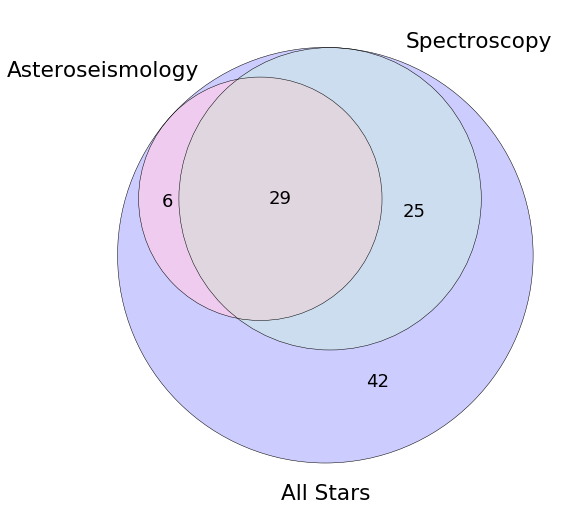

In [340]:
v = venn3([seismic_names,spec_names,all_names],set_labels=labels,alpha=0.2)
lbl = v.get_label_by_id('001')
x, y = lbl.get_position()
lbl.set_position((x, y-0.1))  # Or whatever

venn3_circles([seismic_names,spec_names,all_names],linewidth=0.5);
plt.savefig('../paper/venn.png',bbox_inches='tight')

In [341]:
for name in spec_names:
    if name not in all_names:
        print 'Spectroscopy:',name,'not in main catalogue'

for name in seismic_names:
    if name not in all_names:
        print 'Asteroseismology:',name,'not in main catalogue'
        
for name in seismic_names:
    if name not in spec_names:
        print 'Asteroseismic data available for',name,'but not spectroscopy'
        
for name in diff['Object']:
    if name not in seismic_names:
#         print 'Abundances data available for',name,'but not asteroseismology'
        print name


Asteroseismic data available for HD_176209 but not spectroscopy
Asteroseismic data available for HD_189750 but not spectroscopy
Asteroseismic data available for BD+42_3150 but not spectroscopy
Asteroseismic data available for HD_182354 but not spectroscopy
Asteroseismic data available for BD+48_2904 but not spectroscopy
Asteroseismic data available for HD_189636A but not spectroscopy
BD+43_3064
HD_179959
HD_185351
HD_187217
HD_188629
HD_188875


In [381]:
seismic[seismic['Star_ID']=='HD_189636']

Star_ID,Dnu,Dnu_err,Numax,Numax_err,eps,eps_err
str10,float64,float64,float64,float64,float64,float64
HD_189636,2.9103268982809842,0.013248235493462875,25.970144308219286,0.7419635016983703,0.9683943365400706,0.03773314934951546


BD+36_3564
BD+39_3577
BD+43_3064
BD+43_3171
BD+43_3213
BD+48_2955
HD_174020
HD_174829
HD_175740
HD_175884
HD_178797
